# Render all the objects in obj2d.s

In [2]:
def getFaceData(face_data, verts):
    faces_string = face_data
    faces = [x.strip() for x in faces_string.split('\n') if x.strip()][:-1]
    faces = [x.split('\t')[0].split(' ')[1] for x in faces]
    no_faces = int(faces[0])
    faces = faces[1:]
    pairs_string = verts
    pairs = [int(x) for x in pairs_string.split()[1].split(',')]
    
    vertices = []
    intensities = []
    colors = []
    for i in range(0,len(faces),5):
        color = int(faces[i][-2:],16)
        colors += [color]

        index1 = int(faces[i+1].split(',')[0].strip('$'))
        index2 = int(faces[i+2].split(',')[0].strip('$'))
        index3 = int(faces[i+3].split(',')[0].strip('$'))
        vertex1 = tuple(pairs[index1*2:(index1*2)+2])
        vertex2 = tuple(pairs[index2*2:(index2*2)+2])
        vertex3 = tuple(pairs[index3*2:(index3*2)+2])
        vertices += [[vertex1,vertex2,vertex3]]

        intensity1 = int(faces[i+1].split(',')[1][1:3],16)
        intensity2 = int(faces[i+2].split(',')[1][1:3],16)
        intensity3 = int(faces[i+3].split(',')[1][1:3],16)
        intensities += [(intensity1,intensity2,intensity3)]
    return (no_faces, colors, intensities, vertices)

Had to clean up `obj2d.s` a bit. The claws are split out into a separate file `claws.s`.

In [3]:
data = open("obj2d_cleaned.s").read().split(":")
poly_data = []
poly_names = []
for i in range(1,len(data),2):
    poly_name = data[i-1].splitlines()[-1]
    poly_names += [poly_name]
    poly_data += [getFaceData(data[i],data[i+1])]

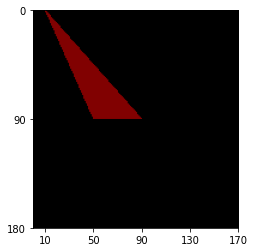

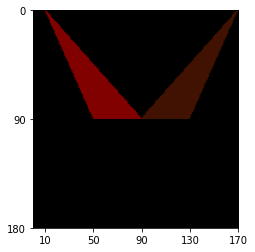

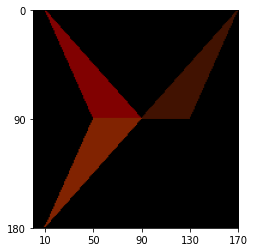

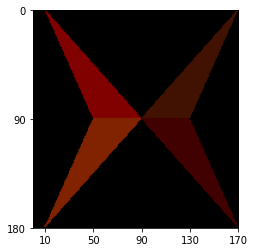

In [43]:
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cry_rgb as cry

flatten = lambda l: [e for sublist in l for e in sublist]
flipper = poly_data[0]

no_faces, colors, intensities, vertices = flipper

for n in range(1,5):
    # Scale the vertices up * 10 so we get a decent size image.
    scaled_vertices = [
        [(x*10,y*10) for (x,y) in verts]
        for verts in vertices
    ]

    # Get the xs and ys so we can use them in our dimensions
    xs = [x for (x,y) in flatten(scaled_vertices)]
    ys = [y for (x,y) in flatten(scaled_vertices)]
    x_offset = abs(min(xs) if min(xs) < 0 else 0)
    y_offset = abs(min(ys) if min(ys) < 0 else 0)
    height = max(ys) + y_offset
    width = max(xs) + x_offset
    im = Image.new('RGB', (width+2, height+2))
    draw = ImageDraw.Draw(im)

    for i,vertex in enumerate(scaled_vertices[:n]):
        vertex = [(x+x_offset,y+y_offset) for x,y in vertex]
        # FIXME: Get the intensity value right here.
        color = cry.cry_to_rgb2(colors[i],intensities[i][0])
        draw.polygon(vertex, fill = color)
    fig, ax = plt.subplots()
    # Offset the plot ticks to allow for negative values
    ax.imshow(im,extent=[min(min(xs),0), max(xs), min(min(ys),0), max(ys)])

    # Only use the vertices for ticks in our graph
    plt.xticks(list(sorted(set(xs))))
    plt.yticks(list(sorted(set(ys))))
    ax.set_yticklabels([180,90,0])
    plt.savefig(f"flipper/flipper_face_{n}.png", bbox_inches='tight')